In [14]:
from tensorflow.keras.utils import PyDataset
from numpy import arange, ceil
from tensorflow.io import decode_png, read_file
from tensorflow.image import crop_and_resize
from tensorflow import expand_dims, stack
from pandas import concat, read_csv, DataFrame
from pathlib import Path


class CroppedImageDataset(PyDataset):
    def __init__(self, image_paths, labels, batch_size=32, crop_box=(0.21, 0.48, 0.86, 0.71), target_size=(300, 300)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.crop_box = crop_box,
        self.target_size = target_size
        self.indices = arange(len(image_paths))

    def __len__(self):
        return int(ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, batch_index):
        batch_indices = self.indices[batch_index * self.batch_size: (batch_index + 1) * self.batch_size]
        batch_images = []
        for idx in batch_indices:
            image = decode_png(read_file(str(self.image_paths[idx])), channels=1)
            image = crop_and_resize(expand_dims(image, 0), self.crop_box, (0,), self.target_size)[0]
            batch_images.append(image)
        batch_images = stack(batch_images)
        batch_labels = self.labels[batch_indices]
        return batch_images, batch_labels


csv_index_column = 0
csv_use_columns = 0, 2, 3, 4, 5, 6, 7
combined_role_stats = concat(
    (
        read_csv('datasets/role_defeat.csv', index_col=csv_index_column, usecols=csv_use_columns),
        read_csv('datasets/role_draw.csv', index_col=csv_index_column, usecols=csv_use_columns),
        read_csv('datasets/role_victory.csv', index_col=csv_index_column, usecols=csv_use_columns)
    ),
    keys=['defeat', 'draw', 'victory']
)
digitwise_label_df = DataFrame()
for column in combined_role_stats.columns:
    for digit_pos in range(len(str(combined_role_stats[column].max())) - 1, -1, -1):
        digitwise_label_df[f'{column}{digit_pos}'] = combined_role_stats[column] // 10 ** digit_pos % 10
image_paths = list(Path('datasets').rglob('*.png'))
label_matrix = digitwise_label_df.values.reshape(-1, 210)
num_images = len(image_paths)
num_labels = len(label_matrix)
assert num_images == num_labels, f'Number of image files ({num_images}) does not match number of label entries ({num_labels}).'
dataset = CroppedImageDataset(image_paths, label_matrix)

In [15]:
X, y = dataset[0]

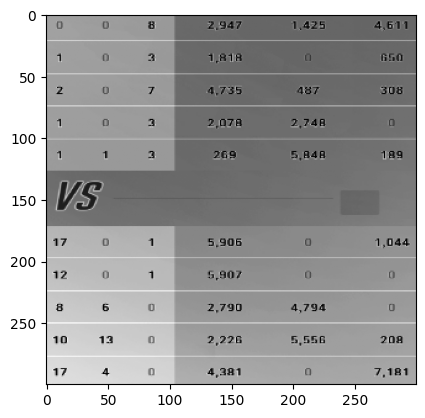

In [16]:
from matplotlib.pyplot import imshow, show

imshow(X[0], 'binary')
show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(ndarray_png.reshape(-1, 1)).reshape(-1, 300, 300, 1)
int_outputs = 210
y = frame_column.values.reshape(-1, int_outputs).T
int_slice = -10
X_train, tuple_y_train = X[:int_slice], tuple(y[:, :int_slice])
X_valid, tuple_y_valid = X[int_slice:], tuple(y[:, int_slice:])
X_train.shape, len(tuple_y_train), X_valid.shape, len(tuple_y_valid)

((889, 300, 300, 1), 210, (10, 300, 300, 1), 210)

In [9]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

X_shape = X_train.shape[1:]

In [26]:
clear_session()
inputs = Input(X_shape)
flatten = Flatten()(inputs)
dense_1 = Dense(300, 'relu')(flatten)
dense_2 = Dense(100, 'relu')(dense_1)
outputs = tuple(Dense(10, 'softmax', name=f'dense_3_{i}')(dense_2) for i in range(1, int_outputs + 1))
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 90000)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300)       │ 27,000,300 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     30,100 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_1 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_2 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_3 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_4 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_5 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_6 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_7 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_8 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_9 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_10 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_11 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_12 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_13 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_14 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_15 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_16 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_17 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_18 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_19 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_20 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 27,242,500 (103.92 MB)

 Trainable params: 27,242,500 (103.92 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import Callback
from numpy import array


class Logger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f'Epoch {epoch + 1}/{self.params["epochs"]}' +
            f'\nloss: {logs["loss"]:.4f}' +
            f' - accuracy: {array([logs[f"dense_3_{i}_accuracy"] for i in range(1, int_outputs + 1)]).mean():.4f}' +
            f' - val_loss: {logs["val_loss"]:.4f}' +
            f' - val_accuracy: {array([logs[f"val_dense_3_{i}_accuracy"] for i in range(1, int_outputs + 1)]).mean():.4f}'
        )

In [28]:
model.compile('SGD', 'sparse_categorical_crossentropy', metrics=['accuracy'] * int_outputs)
history = model.fit(
    X_train,
    tuple_y_train,
    epochs=1000,
    verbose=0,
    callbacks=(EarlyStopping(patience=10, restore_best_weights=True), Logger()),
    validation_data=(X_valid, tuple_y_valid)
)

2025-09-28 07:37:04.954034: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:04.963266: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.198257: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.235718: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.237724: I extern

Epoch 1/1000
loss: 842547986432.0000 - accuracy: 0.2901 - val_loss: 461.0714 - val_accuracy: 0.3181
Epoch 2/1000
loss: 446.5577 - accuracy: 0.3421 - val_loss: 433.7435 - val_accuracy: 0.3571
Epoch 3/1000
loss: 402.9878 - accuracy: 0.3886 - val_loss: 373.7462 - val_accuracy: 0.4124
Epoch 4/1000
loss: 352.2129 - accuracy: 0.4315 - val_loss: 344.7107 - val_accuracy: 0.4248
Epoch 5/1000
loss: 335.7769 - accuracy: 0.4371 - val_loss: 337.0344 - val_accuracy: 0.4219
Epoch 6/1000
loss: 330.0737 - accuracy: 0.4389 - val_loss: 334.0575 - val_accuracy: 0.4181
Epoch 7/1000
loss: 327.5916 - accuracy: 0.4394 - val_loss: 332.8746 - val_accuracy: 0.4181
Epoch 8/1000
loss: 326.4442 - accuracy: 0.4395 - val_loss: 332.0260 - val_accuracy: 0.4190
Epoch 9/1000
loss: 325.8358 - accuracy: 0.4399 - val_loss: 331.3776 - val_accuracy: 0.4219
Epoch 10/1000
loss: 325.4693 - accuracy: 0.4393 - val_loss: 331.3204 - val_accuracy: 0.4181
Epoch 11/1000
loss: 325.2470 - accuracy: 0.4394 - val_loss: 331.2391 - val_accur

In [29]:
y_proba = array(model.predict(X_valid[:1])).argmax(2).reshape(10, 21)
y_proba

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[1, 6, 0, 3, 0, 5, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 1, 7, 2],
       [1, 2, 0, 0, 0, 6, 0, 7, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 4, 0, 0, 0, 8, 0, 9, 5, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 4, 0, 5, 0, 3, 1, 4, 0, 0, 8, 1, 7, 6, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 6, 0, 2, 0, 0, 0, 0, 5, 6, 3, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 2, 0, 5, 0, 0, 0, 9, 1, 0, 0, 0, 0, 0, 0, 5, 6, 3, 4],
       [1, 5, 0, 0, 0, 8, 0, 6, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 7, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 1, 8, 0, 5, 0, 3, 0, 0, 0, 0, 6, 4, 4, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 6, 0, 2, 0, 0, 0, 0, 6, 8, 7, 3, 0, 0, 0, 0, 0]])

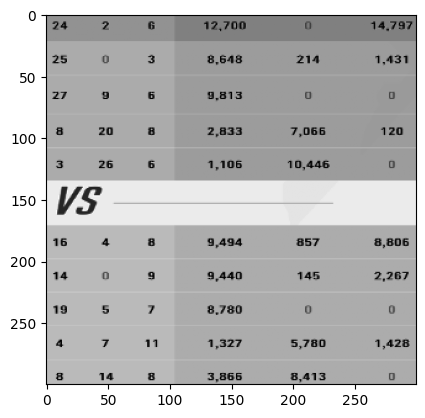

In [30]:
imshow(X_valid[0], 'binary')
show()

In [31]:
array(tuple_y_valid)[:, 0].reshape(10, 21)

array([[2, 4, 0, 2, 0, 6, 1, 2, 7, 0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 7],
       [2, 5, 0, 0, 0, 3, 0, 8, 6, 4, 8, 0, 0, 2, 1, 4, 0, 1, 4, 3, 1],
       [2, 7, 0, 9, 0, 6, 0, 9, 8, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 8, 2, 0, 0, 8, 0, 2, 8, 3, 3, 0, 7, 0, 6, 6, 0, 0, 1, 2, 0],
       [0, 3, 2, 6, 0, 6, 0, 1, 1, 0, 6, 1, 0, 4, 4, 6, 0, 0, 0, 0, 0],
       [1, 6, 0, 4, 0, 8, 0, 9, 4, 9, 4, 0, 0, 8, 5, 7, 0, 8, 8, 0, 6],
       [1, 4, 0, 0, 0, 9, 0, 9, 4, 4, 0, 0, 0, 1, 4, 5, 0, 2, 2, 6, 7],
       [1, 9, 0, 5, 0, 7, 0, 8, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 7, 1, 1, 0, 1, 3, 2, 7, 0, 5, 7, 8, 0, 0, 1, 4, 2, 8],
       [0, 8, 1, 4, 0, 8, 0, 3, 8, 6, 6, 0, 8, 4, 1, 3, 0, 0, 0, 0, 0]])

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout

clear_session()
input_ = Input(X_shape)
conv_2d_1 = Conv2D(64, 7, padding='same', activation='relu', kernel_initializer='HeNormal')(input_)
max_pool_2d_1 = MaxPool2D()(conv_2d_1)
conv_2d_2 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(max_pool_2d_1)
conv_2d_3 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(conv_2d_2)
max_pool_2d_2 = MaxPool2D()(conv_2d_3)
conv_2d_4 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(max_pool_2d_2)
conv_2d_5 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(conv_2d_4)
max_pool_2d_3 = MaxPool2D()(conv_2d_5)
flatten = Flatten()(max_pool_2d_3)
dense_1 = Dense(128, 'relu', kernel_initializer='HeNormal')(flatten)
dropout_1 = Dropout(.5)(dense_1)
dense_2 = Dense(64, 'relu', kernel_initializer='HeNormal')(dropout_1)
dropout_2 = Dropout(.5)(dense_2)
dense_3 = [Dense(10, 'softmax', name=f'dense_3_{i}')(dropout_2) for i in range(1, int_outputs + 1)]
model = Model(inputs=input_, outputs=dense_3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 150, 150,  │    147,584 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 75, 75,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │    590,080 │ conv2d_3[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 350464)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 44,859,520 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_1 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_2 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_3 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_4 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_5 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_6 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_7 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_8 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,240,308 (176.39 MB)

 Trainable params: 46,240,308 (176.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile('nadam', 'sparse_categorical_crossentropy', metrics=['accuracy'] * int_outputs)
history = model.fit(
    X_train,
    tuple_y_train,
    16,
    epochs=1000,
    verbose=0,
    callbacks=(EarlyStopping(patience=10, restore_best_weights=True), Logger()),
    validation_data=(X_valid, tuple_y_valid)
)

Epoch 1/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 2/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 3/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 4/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 5/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 6/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 7/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 8/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 9/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 10/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 11/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543


F0000 00:00:1759046499.642028    7704 bfc_allocator.cc:719] Check failed: h != kInvalidChunkHandle 
